# Prophet Project

Best article ever: https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7/#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.

## 1. Build Model

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('nyc_data.csv').rename(columns = {'Date': 'ds', 'Demand': 'y'}) # Prophet requirements : Date -> DS, target -> y
data['ds'] = pd.to_datetime(data['ds'], format = '%m/%d/%Y')  # Prophet requirements : Date format -> Y/M/D
print(data.shape)
data.head()

(2192, 7)


,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


In [3]:
## Easter Holiday (paques)
dates_easter = data[data.Easter == 1].ds
easter_data = pd.DataFrame({'holiday': 'Easter',
              'ds': dates_easter,
              'Lower_window': -5,   # how many days before easter we are seeing kind of impact
              'Upper_window': 2})   # how many days after easter

dates_thanksgiving = data[data.Thanksgiving == 1].ds
thankgiving_data = pd.DataFrame({'holiday': 'Thanksgiving',
              'ds': dates_thanksgiving,
              'Lower_window': -3,   
              'Upper_window': 5})   

dates_christmas= data[data.Christmas == 1].ds
christmas_data = pd.DataFrame({'holiday': 'Christmas',
              'ds': dates_christmas,
              'Lower_window': -7,  
              'Upper_window': 7})  


data_events = pd.concat([easter_data, thankgiving_data, christmas_data]).reset_index(drop = True)
data_events.head()

,holiday,ds,Lower_window,Upper_window
0,Easter,2015-04-05,-5,2
1,Easter,2016-03-27,-5,2
2,Easter,2017-04-16,-5,2
3,Easter,2018-04-01,-5,2
4,Easter,2019-04-21,-5,2


In [4]:
data_final = data.drop(columns = ['Easter',	'Thanksgiving', 'Christmas'])
data_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


## Prophet Model

### Prophet Parameters

* Seasonality: 'Est-ce qu’il y a des schémas qui reviennent chaque année, semaine ou jour?'
* Seasonality_mode: "Est-ce que les variations saisonnières s'ajoutent (additive) ou se multiplient (multiplicative)?"
* Holidays: "Nous pouvons donner un tableau avec des jours fériés ou dates spéciales" (les ventes changent à Hanouka ? Prophet peut l'apprendre)
* Seasonality_prior_scale: Contrôle à quel point Prophet peut forcer un effet saisonnier - Valeur élevée = plus de liberté pour détecter des saisons
* Holiday_prior_scale: Pareil que le précédent mais pour les jours fériés - Valeur élevée = Prophet s’adapte plus aux changements sur ces jours-là.
* Changepoint_prior_scale: Permettre a Prophet de faire des changements dans la tendance - Valeur basse il reste "rigide", haute + "flexible". 

The main parameters to tune: `Seasonality_prior_scale`, `Holiday_prior_scale`, `Changepoint_prior_scale`

In [5]:
from prophet import Prophet

m = Prophet(growth = 'linear',
            holidays = data_events,
            seasonality_mode = 'multiplicative', 
            seasonality_prior_scale = 10.0, 
            holidays_prior_scale = 10, 
            changepoint_prior_scale = 0.05)

m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(data_final)

14:57:10 - cmdstanpy - INFO - Chain [1] start processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing


### Cross-Validation

Cross-Validation means tying the model several times in different testing situation. Cross-Validation is important for Time-Series to test the model in different seasonal period. 

**Two Types of Cross-Validation** 
* Rolling Forecast: On entraîne le modèle sur une période, puis on le teste sur la suivante, en agrandissant la période d’entraînement à chaque fois.
* Sliding Forecast: On garde une fenêtre d’entraînement de taille fixe qui glisse dans le temps, comme une fenêtre qui avance étape par étape

**Résumé de ce que le modèle fais**

* Entraîne sur les 2012 premiers jours -> Teste les 31 jours suivants -> Avance de 16 jours -> Réentraîne sur 2012 + 16 jours -> Teste encore 31 jours
Il répète jusqu’à ce que la fin de la série arrive.

Le but est:
* de vérifier les performances du modèle dans plusieurs périodes (pas qu’à la fin)
* de voir s’il prédit bien pendant l’été, l’hiver, etc.
* d’avoir des métriques plus fiables (MAE, RMSE...) sur plusieurs cas

In [6]:
from prophet.diagnostics import cross_validation

# Taille du 1er entrainement - Ici garder 6 mois pour la prédiction (2012 jours d'entrainement / 2192)
lenght_test = data.shape[0] - 180  

data_cross = cross_validation(model = m,
                              horizon = '31 days',      # Combien de jours nous voulons prédire (fenêtre de test)
                              period = '16 days',       # Tous les combien de jours Prophet refait une prédiction
                              initial = '2012 days',
                              parallel = 'processes')   # Make it faster

14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1]

In [7]:
# cutoff - when the forecast was done
print(data_cross.shape)
data_cross.head()

(310, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.308336,542.649404,677.651225,571.069531,2020-07-09
1,2020-07-11,722.244121,654.649887,788.374108,677.106981,2020-07-09
2,2020-07-12,637.834962,573.177386,701.840732,619.572774,2020-07-09
3,2020-07-13,769.402663,701.146441,834.941257,808.932621,2020-07-09
4,2020-07-14,638.199930,567.730885,708.218874,661.791644,2020-07-09


In [8]:
data_cross.cutoff.unique()

<DatetimeArray>
['2020-07-09 00:00:00', '2020-07-25 00:00:00', '2020-08-10 00:00:00',
 '2020-08-26 00:00:00', '2020-09-11 00:00:00', '2020-09-27 00:00:00',
 '2020-10-13 00:00:00', '2020-10-29 00:00:00', '2020-11-14 00:00:00',
 '2020-11-30 00:00:00']
Length: 10, dtype: datetime64[ns]

### Checking Performances Metrics

In [9]:
from prophet.diagnostics import performance_metrics

metrics = performance_metrics(data_cross)
mae_mean, mape_mean = metrics.mae.mean(), metrics.mape.mean() * 100

print(f'MEA: {mae_mean:.2f}')
print(f'MAPE: {mape_mean:.2f}')
metrics.head()

MEA: 43.44
MAPE: 5.89


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,3002.700035,54.796898,45.389835,0.061403,0.063607,0.062623,0.767742
1,5 days,2927.790823,54.109064,45.226254,0.063172,0.065373,0.064063,0.796774
2,6 days,3621.638802,60.180053,51.035099,0.070539,0.065373,0.072067,0.735484
3,7 days,2832.797988,53.224036,43.030150,0.060634,0.058490,0.061740,0.735484
4,8 days,2783.839389,52.762102,40.885388,0.056475,0.054781,0.058025,0.735484


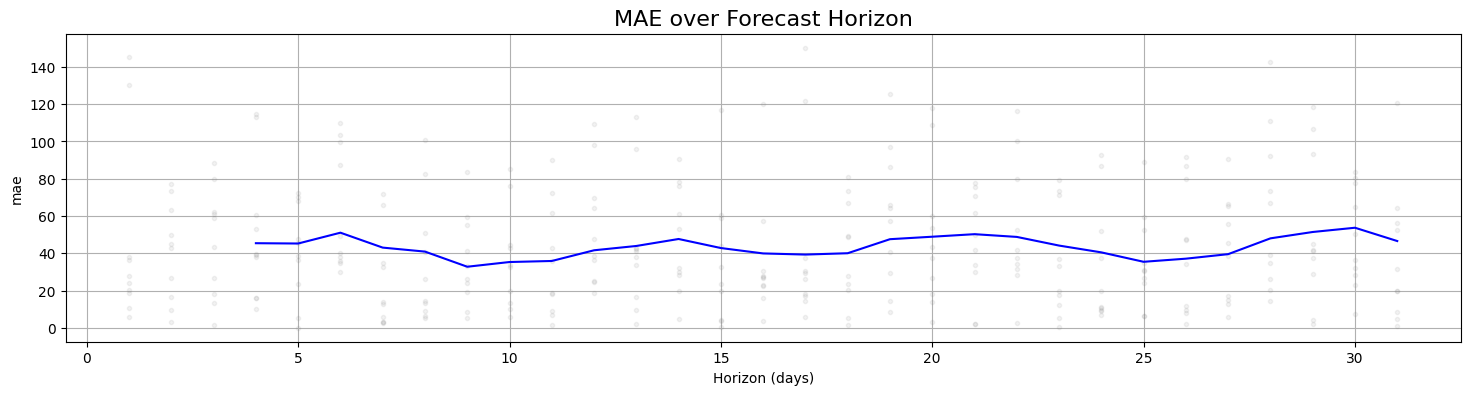

In [10]:
from prophet.plot import plot_cross_validation_metric

# Nous nous attendons a ce que l'erreur évolue avec le temps car le futur est plus imprévisible
# Nous devons tout de même vérifier que l'erreur n'explose pas 
fig = plot_cross_validation_metric(data_cross, metric = 'mae')
fig.set_size_inches(18, 4)
fig.axes[0].set_title("MAE over Forecast Horizon", fontsize=16)
plt.show()

### Parameters Tuning

In [11]:
from sklearn.model_selection import ParameterGrid

params_grid = {'seasonality_mode': ['multiplicative', 'additive'],
               'seasonality_prior_scale': [5, 10, 20],
               'holidays_prior_scale': [5, 10, 20],
               'changepoint_prior_scale': [0.01, 0.05, 0.1]}

grid_values = ParameterGrid(param_grid = params_grid)
print(f'Possibilities: {len(grid_values)}')
print(list(grid_values))

Possibilities: 54
[{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'm

In [ ]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
logging.getLogger('prophet').setLevel(logging.CRITICAL)

MAE = {}
i = 0

for params in grid_values:
    print(f'{i} / {len(grid_values)}')
    m = Prophet(holidays = data_events,
                seasonality_mode = params['seasonality_mode'],
                seasonality_prior_scale = params['seasonality_prior_scale'], 
                holidays_prior_scale = params['holidays_prior_scale'], 
                changepoint_prior_scale = params['changepoint_prior_scale'])
    m.add_regressor('Temperature')
    m.add_regressor('Marketing')
    m.fit(data_final)

    data_cv = cross_validation(model = m, horizon = '31 days', period = '16 days', initial = '2012 days', parallel = 'processes')
    metrics = performance_metrics(data_cv, metrics = ['mae']).mae.mean()
    MAE[metrics] = params
    i += 1

In [13]:
# best_params = pd.DataFrame(grid_values)
# best_params['MAE'] = mae # if list

min_metric = 1e5
for metric in MAE.keys():
    if metric < min_metric:
        min_metric = metric

print(min_metric)
BEST_PARAMS = MAE.get(min_metric)
BEST_PARAMS

40.51143155284261


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 5,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 5}

### Final Model

In [14]:
m = Prophet(**BEST_PARAMS)
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(data_final)

data_cross = cross_validation(model = m,
                              horizon = '31 days',      
                              period = '16 days',     
                              initial = '2012 days',
                              parallel = 'processes')   

14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1

In [15]:
data_cross.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,619.590852,549.548281,691.178300,571.069531,2020-07-09
1,2020-07-11,732.336570,665.626420,795.233376,677.106981,2020-07-09
2,2020-07-12,650.660441,581.277692,717.088999,619.572774,2020-07-09
3,2020-07-13,779.696795,710.367187,843.233427,808.932621,2020-07-09
4,2020-07-14,652.765874,582.619587,722.917321,661.791644,2020-07-09


## 2. Forecasting

In [70]:
data_future = pd.read_csv('future.csv').rename(columns = {'Date': 'ds', 'Demand': 'y'})
data_future['ds'] = pd.to_datetime(data_future['ds'], format = '%m/%d/%Y')

date_future = data_future.ds

print(data_future.shape)
data_future.head()

(31, 7)


,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2021-01-01,NaN,0,0,0,5.00,154.221
1,2021-01-02,NaN,0,0,0,11.11,264.805
2,2021-01-03,NaN,0,0,0,3.89,115.499
3,2021-01-04,NaN,0,0,0,6.67,124.650
4,2021-01-05,NaN,0,0,0,5.56,77.968


In [71]:
data_future = pd.concat([data, data_future]).reset_index(drop = True)
data_future.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


In [72]:
## Easter Holiday (paques)
dates_easter = data_future[data_future.Easter == 1].ds
easter_data = pd.DataFrame({'holiday': 'Easter',
              'ds': dates_easter,
              'Lower_window': -5,   # how many days before easter we are seeing kind of impact
              'Upper_window': 2})   # how many days after easter

dates_thanksgiving = data_future[data_future.Thanksgiving == 1].ds
thankgiving_data = pd.DataFrame({'holiday': 'Thanksgiving',
              'ds': dates_thanksgiving,
              'Lower_window': -3,   
              'Upper_window': 5})   

dates_christmas= data_future[data_future.Christmas == 1].ds
christmas_data = pd.DataFrame({'holiday': 'Christmas',
              'ds': dates_christmas,
              'Lower_window': -7,  
              'Upper_window': 7})  


data_events_future = pd.concat([easter_data, thankgiving_data, christmas_data]).reset_index(drop = True)
data_events_future.head()

,holiday,ds,Lower_window,Upper_window
0,Easter,2015-04-05,-5,2
1,Easter,2016-03-27,-5,2
2,Easter,2017-04-16,-5,2
3,Easter,2018-04-01,-5,2
4,Easter,2019-04-21,-5,2


In [73]:
data_final_future = data_future.drop(columns = ['Easter',	'Thanksgiving', 'Christmas'])
data_final_future.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


In [74]:
train = data_final_future.iloc[:-31, :]
predict = data_final_future.iloc[-31:, :]

m = Prophet(**BEST_PARAMS)
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(train)

In [75]:
# Predictions
future = m.make_future_dataframe(periods = len(predict), freq = 'D')
future = pd.concat([future, data_final_future.iloc[:, 2:]], axis = 1)
future.head()

,ds,Temperature,Marketing
0,2015-01-01,3.68,41.305
1,2015-01-02,4.73,131.574
2,2015-01-03,7.23,162.700
3,2015-01-04,10.96,160.281
4,2015-01-05,6.92,51.077


In [76]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Marketing,Marketing_lower,Marketing_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,600.482487,632.733454,761.430158,600.482487,600.482487,-2.167652,-2.167652,-2.167652,9.412484,...,-3.762907,-3.762907,-3.762907,92.606517,92.606517,92.606517,0.0,0.0,0.0,696.570929
1,2015-01-02,600.620746,544.083772,678.612792,600.620746,600.620746,0.124368,0.124368,0.124368,8.540393,...,-89.902659,-89.902659,-89.902659,90.859102,90.859102,90.859102,0.0,0.0,0.0,610.241950
2,2015-01-03,600.759005,652.411797,793.143279,600.759005,600.759005,0.914688,0.914688,0.914688,6.463985,...,24.745328,24.745328,24.745328,89.306693,89.306693,89.306693,0.0,0.0,0.0,722.189700
3,2015-01-04,600.897264,565.795122,698.905425,600.897264,600.897264,0.853267,0.853267,0.853267,3.365985,...,-55.680827,-55.680827,-55.680827,87.972614,87.972614,87.972614,0.0,0.0,0.0,637.408304
4,2015-01-05,601.035523,703.495482,833.755337,601.035523,601.035523,-1.919531,-1.919531,-1.919531,6.721460,...,73.841413,73.841413,73.841413,86.873576,86.873576,86.873576,0.0,0.0,0.0,766.552440


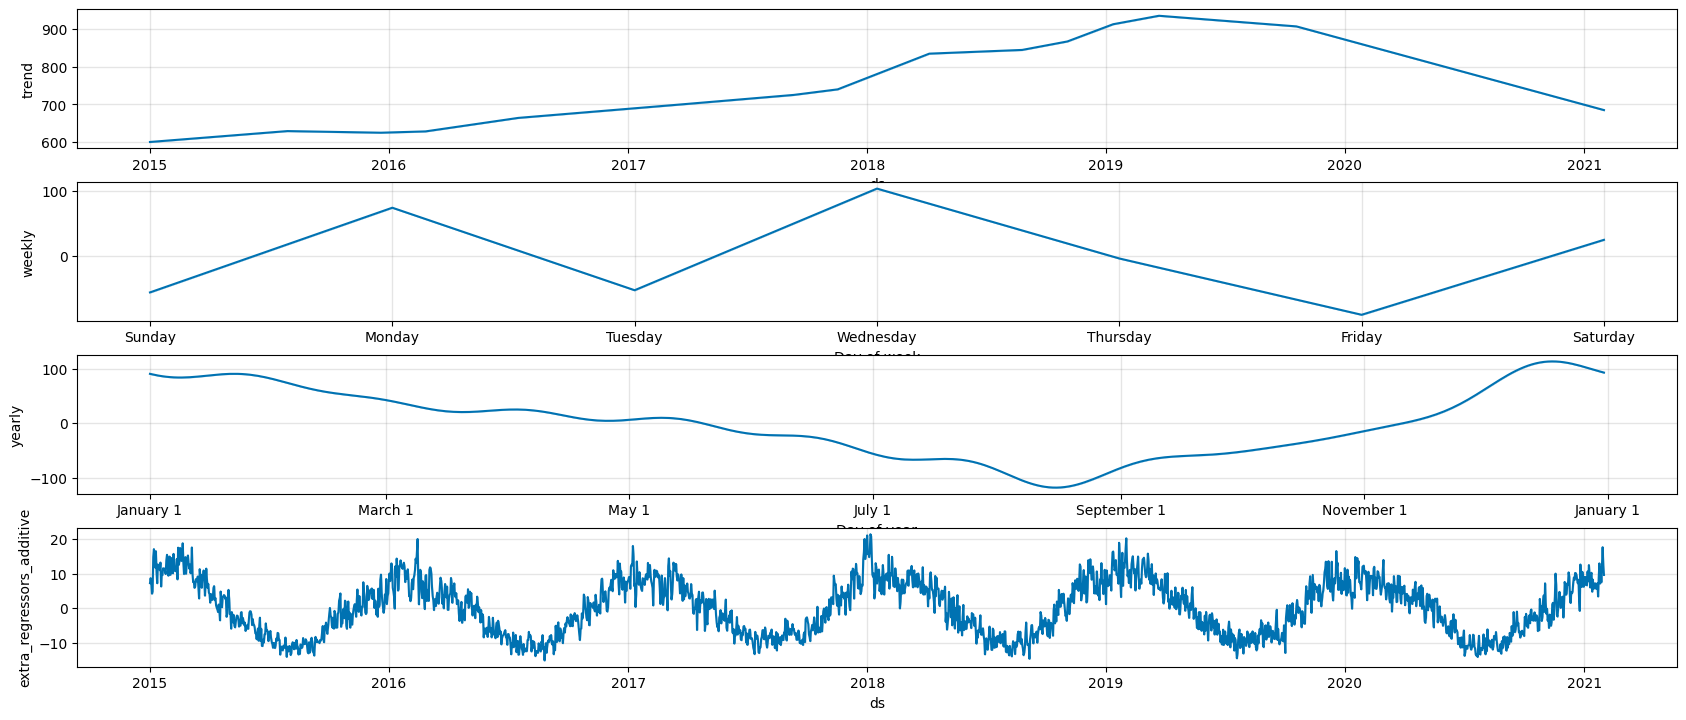

In [77]:
fig = m.plot_components(forecast)
fig.set_size_inches(18, 7)
plt.show()

In [79]:
## Demand Forecast
demand_pred = forecast.yhat[-31:].rename('Prophet')
demand_pred.index = date_future
demand_pred.head()

ds
2021-01-01    710.150713
2021-01-02    820.406038
2021-01-03    740.267230
2021-01-04    866.022100
2021-01-05    738.119841
Name: Prophet, dtype: float64